In [41]:
# import sys
# sys.path.append("../src")

import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

In [42]:
# Paths
folder_path = "../data/raw/features/features"
annotations_path = "../data/raw/features/annotations/static_annotations_averaged_songs_1_2000.csv"

all_features = {}

# Step 1: Aggregate features per song
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath, sep=';')
        
        numeric_df = df.select_dtypes(include=['number'])
        
        if 'frameTime' in numeric_df.columns:
            numeric_df = numeric_df.drop(columns=['frameTime'])
        
        cols_to_remove = [col for col in numeric_df.columns if '_de_' in col]
        numeric_df = numeric_df.drop(columns=cols_to_remove)
        
        feature_means = numeric_df.mean()
        feature_stds = numeric_df.std()
        
        feature_vector = pd.concat([feature_means, feature_stds], axis=0)
        
        track_id = os.path.splitext(filename)[0]
        all_features[track_id] = feature_vector

features_df = pd.DataFrame.from_dict(all_features, orient='index')

# de test
# print(f"Aggregated features shape: {features_df.shape}")
# print(features_df.head())

# Step 2: Load annotations
annotations_df = pd.read_csv(annotations_path)

# Strip any whitespace from column names
annotations_df.columns = annotations_df.columns.str.strip()

# de test
# print("Annotations columns:", annotations_df.columns.tolist())
# print(f"Annotations shape: {annotations_df.shape}")
# print(annotations_df.head())

# Step 3: Prepare annotations for merging
annotations_df = annotations_df.rename(columns={'song_id': 'track_id'})

# Reset index on features_df so track_id is a column
features_df = features_df.reset_index().rename(columns={'index': 'track_id'})

# Ensure track_id columns are strings and stripped (optional but safer)
features_df['track_id'] = features_df['track_id'].astype(str).str.strip()
annotations_df['track_id'] = annotations_df['track_id'].astype(str).str.strip()

# Step 4: Merge features with annotations on 'track_id'
merged_df = pd.merge(features_df, annotations_df, on='track_id', how='inner')

# de test
# print(f"Merged dataset shape: {merged_df.shape}")
print(merged_df.columns.tolist())
# print(merged_df[['track_id', 'valence_mean', 'arousal_mean']].head())

# Step 5: Normalize valence and arousal means to [0,1] for thresholding
val_min, val_max = merged_df['valence_mean'].min(), merged_df['valence_mean'].max()
aro_min, aro_max = merged_df['arousal_mean'].min(), merged_df['arousal_mean'].max()

merged_df['valence_norm'] = (merged_df['valence_mean'] - val_min) / (val_max - val_min)
merged_df['arousal_norm'] = (merged_df['arousal_mean'] - aro_min) / (aro_max - aro_min)

def assign_mood(valence, arousal, threshold=0.5):
    if valence >= threshold and arousal >= threshold:
        return 'happy'
    elif valence >= threshold and arousal < threshold:
        return 'calm'
    elif valence < threshold and arousal >= threshold:
        return 'angry'
    else:
        return 'sad'

merged_df['mood'] = merged_df.apply(lambda row: assign_mood(row['valence_norm'], row['arousal_norm']), axis=1)
print(merged_df[['track_id', 'valence_mean', 'arousal_mean', 'valence_norm', 'arousal_norm', 'mood']].head(10))

# Save merged dataset if needed
# merged_df.to_csv('features_with_annotations.csv', index=False)


['track_id', 'F0final_sma_stddev', 'F0final_sma_amean', 'voicingFinalUnclipped_sma_stddev', 'voicingFinalUnclipped_sma_amean', 'jitterLocal_sma_stddev', 'jitterLocal_sma_amean', 'jitterDDP_sma_stddev', 'jitterDDP_sma_amean', 'shimmerLocal_sma_stddev', 'shimmerLocal_sma_amean', 'logHNR_sma_stddev', 'logHNR_sma_amean', 'audspec_lengthL1norm_sma_stddev', 'audspec_lengthL1norm_sma_amean', 'audspecRasta_lengthL1norm_sma_stddev', 'audspecRasta_lengthL1norm_sma_amean', 'pcm_RMSenergy_sma_stddev', 'pcm_RMSenergy_sma_amean', 'pcm_zcr_sma_stddev', 'pcm_zcr_sma_amean', 'audSpec_Rfilt_sma[0]_stddev', 'audSpec_Rfilt_sma[0]_amean', 'audSpec_Rfilt_sma[1]_stddev', 'audSpec_Rfilt_sma[1]_amean', 'audSpec_Rfilt_sma[2]_stddev', 'audSpec_Rfilt_sma[2]_amean', 'audSpec_Rfilt_sma[3]_stddev', 'audSpec_Rfilt_sma[3]_amean', 'audSpec_Rfilt_sma[4]_stddev', 'audSpec_Rfilt_sma[4]_amean', 'audSpec_Rfilt_sma[5]_stddev', 'audSpec_Rfilt_sma[5]_amean', 'audSpec_Rfilt_sma[6]_stddev', 'audSpec_Rfilt_sma[6]_amean', 'audSpec

k neighbors per class: {np.int64(0): 31, np.int64(1): 32, np.int64(2): 27, np.int64(3): 27}
Mutual kNN graph edges before MST: 13438
Mutual kNN graph not connected, adding MST edges for connectivity...
Final graph edges after MST: 14423
Is final graph connected? True
Data object with mutual kNN + MST graph: Data(x=[1744, 211], edge_index=[2, 14423], y=[1744])


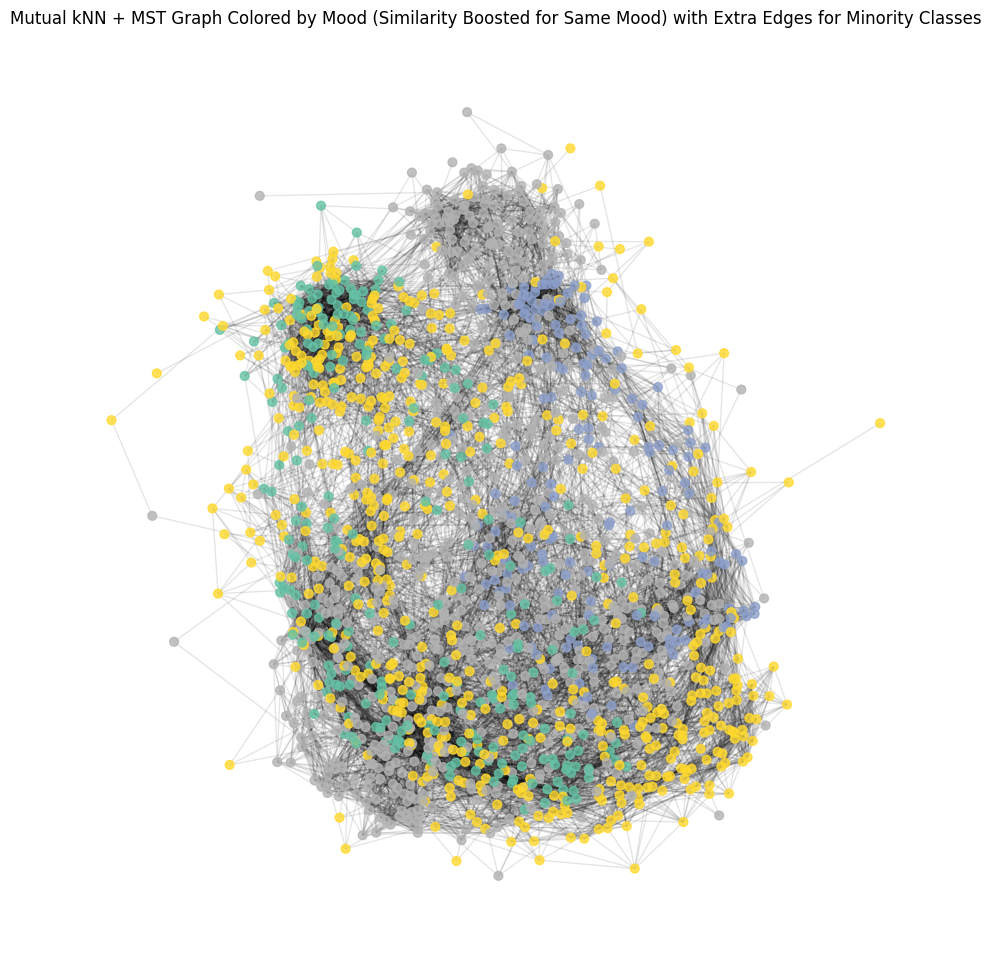

In [40]:
# Assuming merged_df is ready and you excluded columns as before:
exclude_cols = [
    'track_id', 'valence_mean', 'valence_std',
    'arousal_mean', 'arousal_std', 'valence_norm',
    'arousal_norm', 'mood'
]

feature_cols = [col for col in merged_df.columns if col not in exclude_cols]

# Features and labels
X = merged_df[feature_cols].values
labels = merged_df['mood'].values

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

num_nodes = X_normalized.shape[0]
similarity_matrix = cosine_similarity(X_normalized)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Compute class frequencies
unique_classes, counts = np.unique(labels_encoded, return_counts=True)
total_samples = len(labels_encoded)
class_freq = {c: count / total_samples for c, count in zip(unique_classes, counts)}

# Define min and max k
min_k = 15  
max_k = 35 

# Compute per-class k based on inverse frequency (rarer class → higher k)
k_per_class = {}
for c in unique_classes:
    freq = class_freq[c]
    k_per_class[c] = int(min_k + (1 - freq) * (max_k - min_k))

print("k neighbors per class:", k_per_class)

# Adjust similarity by mood match factor before neighbor selection
adjusted_similarity = similarity_matrix.copy()
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if labels_encoded[i] == labels_encoded[j]:
            # Boost similarity if same mood
            adjusted_similarity[i, j] *= 2
            adjusted_similarity[j, i] = adjusted_similarity[i, j]
        else:
            # Leave similarity as is or optionally scale down slightly (not applied here)
            pass

# Find top-k neighbors per node with dynamic k by class on adjusted similarity
top_k_neighbors = []
for i in range(num_nodes):
    node_class = labels_encoded[i]
    k_for_node = k_per_class[node_class]

    sim_scores = adjusted_similarity[i].copy()
    sim_scores[i] = -1  # exclude self
    neighbors = np.argsort(sim_scores)[::-1][:k_for_node]
    top_k_neighbors.append(set(neighbors))

# Build mutual kNN edges
mutual_knn_edges = set()
for i in range(num_nodes):
    for j in top_k_neighbors[i]:
        if i in top_k_neighbors[j]:  # mutual condition
            edge = tuple(sorted((i, j)))
            mutual_knn_edges.add(edge)

# Add extra edges for minority class nodes
minority_class_nodes = [i for i in range(num_nodes) if class_freq[labels_encoded[i]] < 0.3]  # Arbitrary threshold

for node in minority_class_nodes:
    # Explicitly add edges from minority class node to its top-5 neighbors
    sim_scores = adjusted_similarity[node].copy()
    sim_scores[node] = -1  # Exclude self
    neighbors = np.argsort(sim_scores)[::-1][:5]  # Get top-5 neighbors
    for neighbor in neighbors:
        mutual_knn_edges.add(tuple(sorted((node, neighbor))))

print(f"Mutual kNN graph edges before MST: {len(mutual_knn_edges)}")

# Create graph from mutual kNN edges
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(mutual_knn_edges)

# Check connectivity and add MST edges if disconnected
if not nx.is_connected(G):
    print("Mutual kNN graph not connected, adding MST edges for connectivity...")

    distance_matrix = 1 - similarity_matrix  # Use original similarity for MST
    G_full = nx.Graph()
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            G_full.add_edge(i, j, weight=distance_matrix[i, j])

    mst = nx.minimum_spanning_tree(G_full)

    for edge in mst.edges():
        if not G.has_edge(*edge):
            G.add_edge(*edge)

print(f"Final graph edges after MST: {G.number_of_edges()}")
print(f"Is final graph connected? {nx.is_connected(G)}")

# Prepare PyTorch Geometric data object
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
X_tensor = torch.tensor(X_normalized, dtype=torch.float)
labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)

data = Data(x=X_tensor, edge_index=edge_index, y=labels_tensor)
print(f"Data object with mutual kNN + MST graph: {data}")

# Visualize graph colored by mood
unique_moods = np.unique(labels)
color_map = plt.get_cmap('Set2', len(unique_moods))
mood_to_color = {mood: color_map(i) for i, mood in enumerate(unique_moods)}
node_colors = [mood_to_color[mood] for mood in labels]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42, k=0.15)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=40, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title("Mutual kNN + MST Graph Colored by Mood (Similarity Boosted for Same Mood) with Extra Edges for Minority Classes")
plt.axis('off')
plt.show()


In [44]:
# Ensure 'mood' column exists before training
if 'mood' not in merged_df.columns:
    def assign_mood(valence, arousal, threshold=0.5):
        if valence >= threshold and arousal >= threshold:
            return 'happy'
        elif valence >= threshold and arousal < threshold:
            return 'calm'
        elif valence < threshold and arousal >= threshold:
            return 'angry'
        else:
            return 'sad'

    merged_df['mood'] = merged_df.apply(lambda row: assign_mood(row['valence_norm'], row['arousal_norm']), axis=1)

# Exclude unnecessary columns
exclude_cols = ['track_id', 'mood', 'valence_mean', 'valence_std', 'arousal_mean', 'arousal_std', 
                'valence_norm', 'arousal_norm']

feature_cols = [col for col in merged_df.columns if col not in exclude_cols]  # Get the remaining features
features = merged_df[feature_cols].values

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
joblib.dump(scaler, '../models/scaler.save')  # Save scaler for app

data.x = torch.tensor(features_scaled, dtype=torch.float)
# data.edge_index is assumed to be prepared earlier and set already (else load or build it here)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Assign 'mood' as the target labels (data.y)
labels_encoded = le.transform(merged_df['mood'])
data.y = torch.tensor(labels_encoded, dtype=torch.long).to(device)  # Assign mood labels to data.y

# Split data into train, validation, and test sets
# Assuming you have pre-defined masks: train_mask, val_mask, test_mask
# If not, you can define them as shown below by using an 80/10/10 split.

# Randomly split data into train, validation, and test sets
num_nodes = len(merged_df)
train_size = int(num_nodes * 0.8)
val_size = int(num_nodes * 0.1)

# Shuffle nodes and assign masks
indices = torch.randperm(num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[indices[:train_size]] = True

val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[indices[train_size:train_size + val_size]] = True

test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[indices[train_size + val_size:]] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Model definition (unchanged)
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.7):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])  # Use data.y as target labels
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits[mask].argmax(dim=1)  # Get the predicted classes (moods)
        acc = accuracy_score(data.y[mask].cpu(), preds.cpu())  # Compare predictions to true labels (data.y)
    return acc

# Model training and evaluation
hidden_dim = 32
lr = 0.01
dropout = 0.7
num_epochs = 500

model = GraphSAGE(
    input_dim=data.num_node_features,
    hidden_dim=hidden_dim,
    output_dim = len(torch.unique(torch.tensor(labels_encoded))),
    dropout=dropout).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

val_acc_history = []
test_acc_history = []
best_val_acc = 0
best_test_acc = 0

for epoch in range(1, num_epochs + 1):
    loss = train(model, optimizer)
    val_acc = evaluate(model, data.val_mask)
    test_acc = evaluate(model, data.test_mask)

    val_acc_history.append(val_acc)
    test_acc_history.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

mean_val_acc = np.mean(val_acc_history)
mean_test_acc = np.mean(test_acc_history)

print(f"Training with hidden_dim={hidden_dim}, lr={lr}, dropout={dropout}")
print(f"Mean Val Acc: {mean_val_acc:.4f}, Mean Test Acc: {mean_test_acc:.4f}")
print(f"Best Val Acc: {best_val_acc:.4f}, Corresponding Test Acc: {best_test_acc:.4f}")

torch.save(model.state_dict(), '../models/graphsage_model.pth')
np.save('../models/le_classes.npy', le.classes_)
merged_df[['track_id'] + feature_cols + ['mood']].to_csv('../models/merged_features.csv', index=False)

# Save node order used in training for the features matrix
sorted_track_ids = merged_df['track_id'].astype(str).tolist()
np.save('../models/sorted_track_ids.npy', np.array(sorted_track_ids))

# Save feature columns used (optional)
import json
with open('../models/feature_columns.json', 'w') as f:
    json.dump(feature_cols, f)


Epoch 001, Loss: 1.4213, Val Acc: 0.4943, Test Acc: 0.5429
Epoch 010, Loss: 0.8807, Val Acc: 0.6322, Test Acc: 0.6914
Epoch 020, Loss: 0.7111, Val Acc: 0.7759, Test Acc: 0.7943
Epoch 030, Loss: 0.5839, Val Acc: 0.8391, Test Acc: 0.8400
Epoch 040, Loss: 0.4876, Val Acc: 0.8333, Test Acc: 0.8857
Epoch 050, Loss: 0.4477, Val Acc: 0.8736, Test Acc: 0.8743
Epoch 060, Loss: 0.3790, Val Acc: 0.8678, Test Acc: 0.9086
Epoch 070, Loss: 0.3563, Val Acc: 0.8908, Test Acc: 0.9200
Epoch 080, Loss: 0.3287, Val Acc: 0.9080, Test Acc: 0.9257
Epoch 090, Loss: 0.2912, Val Acc: 0.8966, Test Acc: 0.9371
Epoch 100, Loss: 0.2952, Val Acc: 0.8851, Test Acc: 0.9486
Epoch 110, Loss: 0.2527, Val Acc: 0.9138, Test Acc: 0.9429
Epoch 120, Loss: 0.2443, Val Acc: 0.9195, Test Acc: 0.9543
Epoch 130, Loss: 0.2194, Val Acc: 0.9138, Test Acc: 0.9486
Epoch 140, Loss: 0.2011, Val Acc: 0.9310, Test Acc: 0.9429
Epoch 150, Loss: 0.2096, Val Acc: 0.9195, Test Acc: 0.9543
Epoch 160, Loss: 0.1801, Val Acc: 0.9195, Test Acc: 0.94